**This code is for CSoNet-2021 paper "Detecting Hate Speech Contents Using Embedding Models".** 

**The resources of this paper are available at [here](https://github.com/duonghuuphuc/hate-speech-detection)**

# Import Library & Package

In [1]:
# Install Spacy and its en_core_web_lg
!pip install spacy
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [2]:
from sklearn.utils import resample
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from sklearn import metrics

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn.utils.rnn import pack_padded_sequence

from string import punctuation, ascii_lowercase

from imblearn.over_sampling import SMOTE

from gensim.models import KeyedVectors

from tqdm import tqdm

import os
import re
import random
import time
import copy
import logging
import spacy
import json
import gdown
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

logging.basicConfig(format='%(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Read & Prepare Dataset
*   HASOC2019: Remove unused columns, change the column name to class
*   HSOF-3: Remove unused columns, change the label 0 to 1 which mean label Hatespeech become label Offensive and 2 to 0 which mean label of Neither become 0.
*   HS2-2021: Concatenate 2 dataset HASOC2019 and Davidson et Al.

**NOTE**: If you run all the blocks then the dataset's option will be our dataset, HS2-2021. Otherhands, make your decision on which dataset you want to perform.







## **Download Dataset**

In [3]:
!mkdir datasets

### HASOC-2019

In [4]:
!mkdir ./datasets/HASOC2019
!wget -O ./datasets/HASOC2019/english_dataset.tsv https://raw.githubusercontent.com/socialmediaie/HASOC2019/master/data/raw/training_data/english_dataset.tsv
!wget -O ./datasets/HASOC2019/test_english_dataset.tsv https://raw.githubusercontent.com/socialmediaie/HASOC2019/master/data/raw/test_data_gold/english_data.tsv

--2021-07-10 02:12:22--  https://raw.githubusercontent.com/socialmediaie/HASOC2019/master/data/raw/training_data/english_dataset.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1223457 (1.2M) [text/plain]
Saving to: ‘./datasets/HASOC2019/english_dataset.tsv’

./datasets/HASOC201 100%[===================>]   1.17M  --.-KB/s    in 0.05s   

2021-07-10 02:12:23 (23.8 MB/s) - ‘./datasets/HASOC2019/english_dataset.tsv’ saved [1223457/1223457]

--2021-07-10 02:12:23--  https://raw.githubusercontent.com/socialmediaie/HASOC2019/master/data/raw/test_data_gold/english_data.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

### Davidson-2017

In [5]:
!mkdir ./datasets/HSOF-3
!wget -O ./datasets/HSOF-3/labeled_data.csv https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv

--2021-07-10 02:12:23--  https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2546446 (2.4M) [text/plain]
Saving to: ‘./datasets/HSOF-3/labeled_data.csv’

./datasets/HSOF-3/l 100%[===================>]   2.43M  --.-KB/s    in 0.08s   

2021-07-10 02:12:24 (31.1 MB/s) - ‘./datasets/HSOF-3/labeled_data.csv’ saved [2546446/2546446]



### HS2-2021

In [6]:
"""
In this case, you need to upload the file which download from our Github.
"""
!mkdir ./datasets/HS2-2021

## **Prepare Dataset**

In [7]:
class PreprocessData:
  #Regular Expression
  nlp = spacy.load("en_core_web_lg", disable=['parser', 'ner'])
  space_pattern = '\s+'
  giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|''[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  mention_regex1 = '([@#][\w\s]+:)'
  mention_regex2 = '([@#][\w]+)'
  mention_regex3 = '(RT\s)'
  special_character = '[^a-zA-Z\s]'
  consecutive_space1 = '(?:\s\s)'
  consecutive_space2 = '(?:\s{3})'
  consecutive_space3 = '(?:\b\s{2})'
  html_entities = '&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-fA-F]{1,6});'

  def __init__(self):
    self.data_df = None

  def spacyLemmatize(self, sentence):
    sentence = sentence.lower()
    doc = self.nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

  def run(self):
    """
      Remove URL + Space + Emoji + Newline
    """
    for t in tqdm(range(len(self.data_df['text'])), position=0, leave=True):
      if("\n" in self.data_df['text'][t]):
        self.data_df['text'][t] = self.data_df['text'][t].replace("\n", " ")
      parsed_text = re.sub(self.space_pattern, ' ', self.data_df['text'][t])
      parsed_text = re.sub(self.giant_url_regex, '', parsed_text)
      if ("RT" in parsed_text):
        parsed_text = re.sub(self.mention_regex3, '', parsed_text)
      parsed_text = re.sub(self.mention_regex1, '', parsed_text)
      parsed_text = re.sub(self.mention_regex2, '', parsed_text)	
      parsed_text = re.sub(self.html_entities, ' ', parsed_text)
      parsed_text = re.sub(self.special_character, '', parsed_text)
      parsed_text = re.sub(self.consecutive_space2, ' ', parsed_text)
      parsed_text = re.sub(self.consecutive_space1, ' ', parsed_text)
      parsed_text = re.sub(self.consecutive_space3, ' ', parsed_text)
      parsed_text = self.spacyLemmatize(parsed_text)
      parsed_text = parsed_text.replace('-PRON-', '')
      parsed_text = re.sub(self.consecutive_space2, ' ', parsed_text)
      parsed_text = re.sub(self.consecutive_space1, ' ', parsed_text)
      parsed_text = re.sub(self.consecutive_space3, ' ', parsed_text)
      self.data_df['text'][t] = parsed_text.strip()

  def cvToCsv(self, path):
    self.data_df.to_csv(path, index=False, columns=["text", "class"])
  
  def pipeline(self, data_df, name):
    self.data_df = data_df
    self.run()
    self.cvToCsv(name)
    return self.data_df

### HASOC-2019

In [8]:
data_name = "HASOC-2019"
train_file_path = './datasets/HASOC2019/english_dataset.tsv'
test_file_path = './datasets/HASOC2019/test_english_dataset.tsv'
preprocessor = PreprocessData()

logger.info(f"Preprocess train dataset from {train_file_path}")
train_df = pd.read_csv(train_file_path, sep='\t')
train_df = train_df.drop(columns=['task_2', 'task_3', 'text_id'])
train_df = train_df.rename(columns={'task_1': 'class'})
train_df["class"] = train_df["class"].replace({'NOT': 0, 'HOF': 1})
train_df = preprocessor.pipeline(train_df, './datasets/HASOC2019/preprocessed_english_dataset.tsv')

logger.info(f"Preprocess test dataset from {test_file_path}")
test_df = pd.read_csv(test_file_path, sep='\t')
test_df = test_df.drop(columns=['task_2', 'task_3', 'text_id'])
test_df = test_df.rename(columns={'task_1': 'class'})
test_df["class"] = test_df["class"].replace({'NOT': 0, 'HOF': 1})
test_df = preprocessor.pipeline(test_df, './datasets/HASOC2019/preprocessed_hasoc2019_en_test-2919.tsv')

dataset_max_length = train_df['seq_len'] = train_df["text"].apply(lambda words: len(words.split(" ")))
MAX_SEQUENCE_LENGTH = max(dataset_max_length)
is_balance= False

Preprocess train dataset from ./datasets/HASOC2019/english_dataset.tsv
100%|██████████| 5852/5852 [00:17<00:00, 327.86it/s]
Preprocess test dataset from ./datasets/HASOC2019/test_english_dataset.tsv
100%|██████████| 1153/1153 [00:03<00:00, 319.59it/s]


### HSOF-3

In [9]:
data_name = "HSOF-3"
full_file_path = './datasets/HSOF-3/labeled_data.csv'
full_df = pd.read_csv(full_file_path)
train_df, test_df = train_test_split(full_df, random_state=42, test_size=0.1)
preprocessor = PreprocessData()

logger.info(f"Preprocess train dataset from {full_file_path}")
train_df = train_df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither', 'Unnamed: 0'])
train_df['class'] = train_df['class'].replace({0: 1, 2: 0})
train_df = train_df.reset_index().drop(columns=['index'])
train_df = train_df.rename(columns={'tweet': 'text'})
train_df = preprocessor.pipeline(train_df, './datasets/HSOF-3/preprocessed_labeled_data.csv')


logger.info(f"Preprocess train dataset from {full_file_path}")
test_df = test_df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither', 'Unnamed: 0'])
test_df['class'] = test_df['class'].replace({0: 1, 2: 0})
test_df = test_df.reset_index().drop(columns=['index'])
test_df = test_df.rename(columns={'tweet': 'text'})
test_df = preprocessor.pipeline(test_df, './datasets/HSOF-3/preprocessed_test_labeled_data.csv')

dataset_max_length = train_df['seq_len'] = train_df["text"].apply(lambda words: len(words.split(" ")))
MAX_SEQUENCE_LENGTH = max(dataset_max_length)
is_balance= True

Preprocess train dataset from ./datasets/HSOF-3/labeled_data.csv
100%|██████████| 22304/22304 [01:14<00:00, 298.54it/s]
Preprocess train dataset from ./datasets/HSOF-3/labeled_data.csv
100%|██████████| 2479/2479 [00:07<00:00, 318.52it/s]


### HS2-2021

In [10]:
data_name = "HS2-2021"
full_file_path = './datasets/HS2-2021/hs2_2021.csv'
full_df = pd.read_csv(full_file_path)
preprocessor = PreprocessData()

logger.info(f"Preprocess full dataset from {full_file_path}")
train_df = preprocessor.pipeline(full_df, './datasets/HS2-2021/preprocessed_hs2_2021.csv')

logger.info("Spliting Process ...")
train_df, test_df = train_test_split(train_df, random_state=42, test_size=0.1)
logger.info("Done")

dataset_max_length = train_df['seq_len'] = train_df["text"].apply(lambda words: len(words.split(" ")))
MAX_SEQUENCE_LENGTH = max(dataset_max_length)
is_balance= True

FileNotFoundError: ignored

# Word2Vec

In [9]:
url = 'https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download'
output = 'GoogleNews-vectors-negative300.bin.gz'
if not os.path.exists(output):
  gdown.download(url, output, quiet=False)
  !gzip -d GoogleNews-vectors-negative300.bin.gz

Downloading...
From: https://drive.google.com/u/0/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download
To: /content/GoogleNews-vectors-negative300.bin.gz
1.65GB [00:10, 155MB/s]


In [10]:
"""
Upload the hate speech dictionary to the root folder before you run this block.
"""
hate_array = []
if os.path.exists('./Hatespeech.csv'):
  logger.info("Load Hate Speech Dictionary ...")
  hate_file = pd.read_csv('./Hatespeech.csv', header=None)
  hate_array = hate_file[0].values
  logger.info(f"Total unique hatespeech word: {len(hate_array)}")

Load Hate Speech Dictionary ...
Total unique hatespeech word: 766


In [11]:
def get_emb_matrix_by_gensim(word_index, max_features, embedding_file):
    w2v_model = KeyedVectors.load_word2vec_format(embedding_file, binary=True)
    embedding_dim = w2v_model.vectors.shape[1]
    embedding_matrix = np.zeros((max_features, embedding_dim))
    for word, i in word_index.items():
        if i >= max_features: 
            continue
        try:
          embedding_vector = w2v_model.get_vector(word)
        except:
          embedding_vector = w2v_model.get_vector('unk')
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def build_vocab(texts):
    unique_words = set()
    for text in texts:
      unique_words.update([i.strip() for i in text.split(" ") if i.strip()])
    vocab = dict(zip(unique_words, list(range(1, len(unique_words) + 1))))
    return vocab

In [12]:
merged_dataset = pd.concat([train_df, test_df], ignore_index=True)
logger.info("Build vocabulary ...")
dataset_vocab = build_vocab(list(merged_dataset['text'].values))
logger.info("Load word2vec model ...")
embedded_matrix = get_emb_matrix_by_gensim(dataset_vocab, len(dataset_vocab) + 1, './GoogleNews-vectors-negative300.bin')
embedded_matrix = torch.FloatTensor(embedded_matrix)

Build vocabulary ...
Load word2vec model ...
loading projection weights from ./GoogleNews-vectors-negative300.bin
loaded (3000000, 300) matrix from ./GoogleNews-vectors-negative300.bin


# Custom Dataloader
Note: Change self.balance value when you run the code on Davidson et Al. and HS2-2021, its default value is False on HASOC2020 which means that we perform SMOTE on these 2 datasets.

In [13]:
class MyDataset(Dataset):
    def __init__(self, dataframe, max_seq_len, vocab, hate_array, is_balance = False, dataset_type="Train"):
        self.dataset_type = dataset_type
        self.max_seq_len = MAX_SEQUENCE_LENGTH 
        self.vocab = vocab
        self.is_balance = False
        self.examples = self.create_examples(dataframe, hate_array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        example = self.examples[index]
        ex_token_tensor = torch.tensor(example[0], dtype=torch.long)
        ex_label_tensor = torch.tensor(example[1], dtype=torch.long)
        ex_seq_length_tensor = torch.tensor(example[2], dtype=torch.long)
        ex_hate_tensor = torch.tensor(example[3], dtype=torch.long)
        return ex_token_tensor, ex_label_tensor, ex_seq_length_tensor, ex_hate_tensor
      
    @staticmethod
    def visualize(labels):
        g = sns.countplot(labels)
        g.set_xticklabels(['NOT','HOF'])
        plt.show()

    @staticmethod
    def collate_fn(batch):
        all_input_ids, all_labels, all_lens, all_hates = map(torch.stack, zip(*batch))
        all_lens, indices = torch.sort(all_lens, descending=True)
        all_input_ids = all_input_ids[indices]
        all_labels = all_labels[indices]
        return all_input_ids, all_labels, all_lens, all_hates
  
    def create_examples(self, data_df, hate_array):
        data_df = data_df.reset_index()
        examples = []
        sentences = []
        hates = []
        labels = []
        self.visualize(data_df['class'])
        tqdm_bar = tqdm(data_df.iterrows(), desc=f'Create {self.dataset_type} examples: ', total=len(data_df), position=0, leave=True)
        for _, row in tqdm_bar:
            hate_ids = []
            token_ids = [self.vocab[token] for token in str(row['text']).lower().strip().split()[:self.max_seq_len]] 
            for token in str(row['text']).lower().strip().split()[:self.max_seq_len]:
              if token in hate_array:
                hate_ids.append(1)
              else:
                hate_ids.append(0)
            seq_len = len(token_ids)
            hate_len = len(hate_ids)
            if seq_len == 0:
              continue
            if seq_len < self.max_seq_len:
              num_pad = self.max_seq_len - seq_len
              token_ids += [0] * num_pad
            if hate_len < self.max_seq_len:
              num_pad = self.max_seq_len - seq_len
              hate_ids += [0] * num_pad
            if not len(token_ids) == self.max_seq_len:
                logger.info(f"{seq_len} => {len(token_ids)}")
            if self.is_balance and self.dataset_type == 'Train':
              token_ids = torch.LongTensor(token_ids)
              hate_ids = torch.LongTensor(hate_ids)
              sentences.append(token_ids)
              hates.append(hate_ids)
              labels.append(row['class'])
            else:
              examples.append((token_ids, row['class'], seq_len, hate_ids))
        if self.is_balance and self.dataset_type == 'Train':    
          new_sentences = torch.stack(sentences)
          new_labels = torch.LongTensor(labels)
          new_hates = torch.stack(hates)
          smote = SMOTE() 
          x_smote, y_smote = smote.fit_resample(new_sentences, labels)
          hate_smote, y_hate_smote = smote.fit_resample(new_hates, labels)
          for _,ins in enumerate(x_smote):
              indices = np.where(ins==11380)
              new_list = np.delete(ins, indices) 
              examples.append((ins, y_smote[_], len(new_list), hate_smote[_]))
          self.visualize(y_smote)
        for index in range(2):
            logger.info(f"{self.dataset_type} example {index}: ")
            logger.info(f"\tRaw text    : {data_df['text'][index]}")
            logger.info(f"\tToken IDS   : {examples[index][0]}")
            logger.info(f"\tHate IDS    : {examples[index][3]}")
            logger.info(f"\tLabel ID    : {examples[index][1]}")
            logger.info(f"\tSeq length  : {examples[index][2]}")
        return examples

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


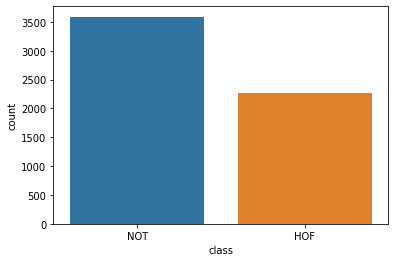

Create Train examples: 100%|██████████| 5852/5852 [00:03<00:00, 1546.16it/s]
Train example 0: 
	Raw text    : watch sports minister kiren rijiju issues statement back ms dhoni over balidaan badge tell bcci to take up the matter with icc and keep government in the know as nation pride be involve
	Token IDS   : [1696, 5067, 9916, 9203, 64, 690, 4551, 8313, 11401, 2134, 160, 467, 9980, 5901, 1362, 6644, 2723, 8384, 5393, 8395, 5168, 10105, 7831, 10756, 6985, 4038, 5393, 1450, 8938, 4546, 7204, 1089, 9969, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	Hate IDS    : [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	Label ID    : 0
	Seq length  : 33
Train example 1: 
	Raw text    : no should remember very clearly that just admit to treason
	Token IDS   : [3646, 8240, 6289, 2078, 1558, 92, 914, 60, 6644, 11186, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

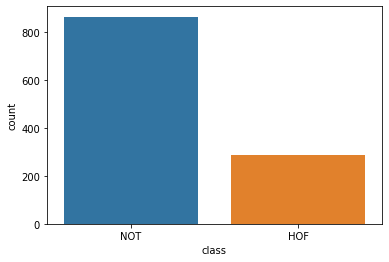

Create Test examples: 100%|██████████| 1153/1153 [00:00<00:00, 1340.55it/s]
Test example 0: 
	Raw text    : west bengal doctor crisis protest doctor agree to meet mamata banerjee in presence of full medium even as be going to go on strike
	Token IDS   : [658, 11505, 8035, 3260, 8183, 8035, 225, 6644, 2297, 45, 6799, 4038, 9809, 2059, 2768, 3944, 2015, 8938, 1089, 670, 6644, 2033, 10982, 3008, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	Hate IDS    : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
	Label ID    : 0
	Seq length  : 24
Test example 1: 
	Raw text    : million people have be force to leave home read more
	Token IDS   : [3708, 5615, 7201, 1089, 9985, 6644, 8074, 6264, 7, 4401, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
if not (os.path.exists(f"train_dataset_{data_name}_cached.pt" ) and os.path.exists( f"test_dataset_{data_name}_cached.pt")):
    train_dataset = MyDataset(train_df, MAX_SEQUENCE_LENGTH, dataset_vocab, hate_array, is_balance, dataset_type='Train')
    test_dataset = MyDataset(test_df, MAX_SEQUENCE_LENGTH, dataset_vocab, hate_array, is_balance, dataset_type='Test')
    torch.save(train_dataset, f"train_dataset_{data_name}_cached.pt" )
    torch.save(test_dataset,  f"test_dataset_{data_name}_cached.pt")
else:
    train_dataset = torch.load(f"train_dataset_{data_name}_cached.pt")
    test_dataset = torch.load( f"test_dataset_{data_name}_cached.pt")

# Models

## Hate Embedding Layer 

In [15]:
class HateEmbedding(nn.Module):
  def __init__(self, max_length):
    super(HateEmbedding, self).__init__()
    self.max_length = max_length
  
  def forward(self, x):
    result = []
    for ins in x:
      hate_embedding = [[1]] * self.max_length if 1 in ins else [[0]] * self.max_length
      result.append(hate_embedding)
    return torch.tensor(result, dtype=torch.long, device=x.device)

## Word2vec + MLP

In [16]:
class MLP(nn.Module):
  def __init__(self, hidden_size, num_classes, vocab_size, embed_dim, pad_idx, dropout_prob, vectors, use_hatedict=False, requires_grad=True):
    super(MLP, self).__init__()
    if use_hatedict:
      self.embedding_layer = nn.Embedding.from_pretrained(vectors, padding_idx=pad_idx)
      self.hate_layer = HateEmbedding(MAX_SEQUENCE_LENGTH)
      embed_dim += 1
    else:
      self.embedding_layer = nn.EmbeddingBag.from_pretrained(vectors, mode="sum")
    if vectors is not None:
      self.embedding_layer.weight.data = nn.Parameter(vectors, requires_grad=requires_grad)
    self.dropout = nn.Dropout(dropout_prob)
    self.layer1 = nn.Linear(embed_dim, hidden_size)
    self.Relu = nn.ReLU()
    self.layer2 = nn.Linear(hidden_size, num_classes)
    self.softmax = nn.Softmax(dim=-1)

  def forward(self, data_input, seq_length, hate_ids=None):
    embedded_data_input = self.embedding_layer(data_input)
    if hate_ids is not None:
      hate_embedded = self.hate_layer(hate_ids)
      embedded_data_input = torch.cat((embedded_data_input, hate_embedded), -1)
      embedded_data_input = torch.sum(embedded_data_input, 1)
    output_layer1 = self.layer1(embedded_data_input)
    relu = self.Relu(output_layer1)
    relu_drop = self.dropout(relu)
    output_layer2 = self.layer2(relu_drop)
    probs = self.softmax(output_layer2)
    return probs 

## Word2vec + BiLSTM

In [17]:
class TextLSTM(nn.Module):
    def __init__(self, hidden_dim, bidirectional, num_lstm_layers, vocab_size, embed_dim, pad_idx, num_labels, dropout_prob, vectors, use_hatedict=False, requires_grad=True):
        super(TextLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.rnn_hidden_dim = hidden_dim // 2 if bidirectional else hidden_dim
        self.embed_layer = nn.Embedding.from_pretrained(vectors, padding_idx=pad_idx)
        if vectors is not None:
            self.embed_layer.weight.data = nn.Parameter(vectors, requires_grad=requires_grad)
        if use_hatedict:
          self.hate_layer = HateEmbedding(MAX_SEQUENCE_LENGTH)
          embed_dim += 1

        self.lstm = nn.LSTM(embed_dim, self.rnn_hidden_dim, bidirectional=bidirectional,
                            num_layers=num_lstm_layers, batch_first=True, 
                            dropout=dropout_prob if num_lstm_layers > 1 else 0)

        self.dropout = nn.Dropout(dropout_prob)
        self.fc_layer = nn.Linear(hidden_dim * num_lstm_layers, num_labels)

    def forward(self, input_ids, seq_len, hate_ids=None):
        batch_size = input_ids.shape[0]
        token_reps = self.embed_layer(input_ids)
        if hate_ids is not None:
          hate_embedded = self.hate_layer(hate_ids)
          token_reps = torch.cat((token_reps, hate_embedded), -1)
          # token_reps = torch.sum(embedded_data_input, 1)
        packed_reps = pack_padded_sequence(token_reps, 
                                           batch_first=True, 
                                           lengths=seq_len.tolist())
        
        h_0 = Variable(torch.zeros(2, batch_size, self.rnn_hidden_dim).cuda())
        c_0 = Variable(torch.zeros(2, batch_size, self.rnn_hidden_dim).cuda())
    
        packed_output, (hn, cn) = self.lstm(packed_reps,  (h_0, c_0))
        hidden = self.dropout(hn)

        hidden = torch.cat([hidden[i, :, :] for i in range(hidden.shape[0])], dim=-1)
        logits = self.fc_layer(hidden)
        return F.softmax(logits)

## Word2vec + CNN

In [36]:
class TextCNN(nn.Module):
    def __init__(self, num_filters, num_labels, max_len, vocab_size, embed_dim, pad_idx, dropout_prob, use_hatedict=False, vectors=None):
        super(TextCNN, self).__init__()
        self.max_len = max_len

        self.embed_layer = nn.Embedding.from_pretrained(vectors, padding_idx=pad_idx)
        if vectors is not None:
          self.embed_layer.weight.data = nn.Parameter(vectors, requires_grad=True)
        if use_hatedict:
          self.hate_layer = HateEmbedding(MAX_SEQUENCE_LENGTH)
          embed_dim += 1 
        self.embed_dim = embed_dim

        self.conv1 = nn.Conv1d(1, num_filters, 1 * embed_dim, stride= embed_dim)
        self.conv2 = nn.Conv1d(1, num_filters, 2 * embed_dim, stride= embed_dim)
        self.conv3 = nn.Conv1d(1, num_filters, 3 * embed_dim, stride= embed_dim)

        self.dropout = nn.Dropout(dropout_prob)

        self.fc_layer = nn.Linear(3 * num_filters, num_labels)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, input_ids, seq_len, hate_ids=None):
        if hate_ids is not None:
          hate_embedded = self.hate_layer(hate_ids)
          word_embedded = self.embed_layer(input_ids)
          input_representation = torch.cat((word_embedded, hate_embedded), -1)
          x = input_representation.view(-1, 1, (self.embed_dim) * self.max_len)
        else:
          x = self.embed_layer(input_ids).view(-1, 1, (self.embed_dim * self.max_len))
        # Convolution
        conv1 = F.relu(self.conv1(x))
        conv2 = F.relu(self.conv2(x))
        conv3 = F.relu(self.conv3(x))

        # Pooling
        pooled_conv1 = F.max_pool1d(conv1, self.max_len - 1 + 1).squeeze(-1)
        pooled_conv2 = F.max_pool1d(conv2, self.max_len - 2 + 1).squeeze(-1)
        pooled_conv3 = F.max_pool1d(conv3, self.max_len - 3 + 1).squeeze(-1)

        x = torch.cat((pooled_conv1, pooled_conv2, pooled_conv3), 1)
        x = self.dropout(x)


        logits = self.fc_layer(x)
        probs = self.softmax(logits)
        return probs

# **Experiments**

## Utils Function

In [18]:
def get_total_time(start_time):
    end = time.time()
    hours, rem = divmod(end - start_time, 3600)
    minutes, seconds = divmod(rem, 60)
    return sum([int(hours*3600), int(minutes*60), int(seconds)])

def caculate_score(actuals, predicts):
    acc_score = metrics.accuracy_score(actuals, predicts)
    f1_macro_score = metrics.f1_score(actuals, predicts, average="macro")
    f1_weighted_score = metrics.f1_score(actuals, predicts, average="weighted")
    report = metrics.classification_report(actuals, predicts, output_dict=True)
    tn, fp, fn, tp = metrics.confusion_matrix(actuals, predicts).ravel()
    f1_0 = round(report['0']['f1-score'], ndigits=2)
    f1_1 = round(report['1']['f1-score'], ndigits=2)
    acc_0 = round(tn/(tn+fp), ndigits=2)
    acc_1 = round(tp/(tp+fn), ndigits=2)
    return acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score

def plot_loss(history):
    plt.plot(history['train_loss'])
    plt.plot(history['eval_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Evaluate'], loc='upper left')
    plt.show()

def eval(model, criterion, eval_iter):
    sum_loss = 0
    predicts, actuals = [], []
    model.eval()
    eval_bar = tqdm(eval_iter, desc=f'\tEval',total=len(eval_iter), position=0, leave=0)
    start_time = time.time()
    with torch.no_grad():
      for batch in eval_bar:
        if len(batch) == 3:
          input_ids, label_ids, seq_lens = batch
        else:
          input_ids, label_ids, seq_lens, _ = batch
        if device == 'cuda':
          input_ids = input_ids.cuda()
          label_ids = label_ids.cuda()
          seq_lens = seq_lens.cuda()
        outs = model(input_ids, seq_lens)
        loss = criterion(outs, label_ids)
        sum_loss += loss.item()
        predicts += [y.argmax().item() for y in outs]
        actuals += label_ids.tolist()
    acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score = caculate_score(actuals, predicts)
    avg_loss = sum_loss / len(eval_iter)
    reports = metrics.classification_report(actuals, predicts, target_names=list(label_maps.keys()), output_dict=True)
    return avg_loss,  (acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score), reports

def train(model, criterion, optimizer, train_iter, eval_iter, scheduler=None):
    history = {'train_loss':[], 'eval_loss':[]}
    best_model = copy.deepcopy(model)
    best_epoch = 0
    min_loss = float('inf')
    counter = 0
    epoch_time = {}
    for epoch in range(num_epochs):
        start = time.time()
        sum_loss = 0
        predicts, actuals = [], []
        model.train()
        train_bar = tqdm(train_iter, desc=f'\tEpoch {epoch}', total=len(train_iter), position=0, leave=0)
        start_time = time.time()
        for batch in train_bar:
          if len(batch) == 3:
            input_ids, label_ids, seq_lens = batch
          else:
            input_ids, label_ids, seq_lens, _ = batch
          if device == 'cuda':
            input_ids = input_ids.cuda()
            label_ids = label_ids.cuda()
            seq_lens = seq_lens.cuda()
          outs = model(input_ids, seq_lens)
          loss = criterion(outs, label_ids)
          loss.backward()
          optimizer.step()
          sum_loss += loss.item()
          predicts += [y.argmax().item() for y in outs]
          actuals += label_ids.tolist()
        train_loss = sum_loss / len(train_iter)
        acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score = caculate_score(actuals, predicts)
        epoch_time[epoch] = get_total_time(start)
        eval_loss, eval_scores, _ = eval(model, criterion, eval_iter)
        if scheduler is not None:
            scheduler.step(eval_loss)
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)
        if eval_loss <= min_loss:
            best_model = copy.deepcopy(model)
            min_loss = eval_loss
            best_epoch = epoch
            counter = 0
        else:
            counter += 1
        if counter >= early_stop:
            break
    plot_loss(history)
    return best_model, best_epoch, epoch_time

def eval_hate(model, criterion, eval_iter):
    sum_loss = 0
    predicts, actuals = [], []
    model.eval()
    eval_bar = tqdm(eval_iter, desc=f'\tEval',total=len(eval_iter), position=0, leave=0)
    start_time = time.time()
    with torch.no_grad():
      for batch in eval_bar:
        input_ids, label_ids, seq_lens, hate_ids = batch
        if device == 'cuda':
          input_ids = input_ids.cuda()
          label_ids = label_ids.cuda()
          seq_lens = seq_lens.cuda()
          hate_ids = hate_ids.cuda()
        outs = model(input_ids, seq_lens, hate_ids)
        loss = criterion(outs, label_ids)
        sum_loss += loss.item()
        predicts += [y.argmax().item() for y in outs]
        actuals += label_ids.tolist()
    acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score = caculate_score(actuals, predicts)
    avg_loss = sum_loss / len(eval_iter)
    reports = metrics.classification_report(actuals, predicts, target_names=list(label_maps.keys()), output_dict=True)
    return avg_loss,  (acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score), reports

def train_hate(model, criterion, optimizer, train_iter, eval_iter, scheduler=None):
    history = {'train_loss':[], 'eval_loss':[]}
    best_model = copy.deepcopy(model)
    best_epoch = 0
    min_loss = float('inf')
    counter = 0
    epoch_time = {}
    for epoch in range(num_epochs):
        start = time.time()
        sum_loss = 0
        predicts, actuals = [], []
        model.train()
        train_bar = tqdm(train_iter, desc=f'\tEpoch {epoch}', total=len(train_iter), position=0, leave=0)
        start_time = time.time()
        for batch in train_bar:
          input_ids, label_ids, seq_lens, hate_ids = batch
          if device == 'cuda':
            input_ids = input_ids.cuda()
            label_ids = label_ids.cuda()
            seq_lens = seq_lens.cuda()
            hate_ids = hate_ids.cuda()
          outs = model(input_ids, seq_lens, hate_ids)
          loss = criterion(outs, label_ids)
          loss.backward()
          optimizer.step()
          sum_loss += loss.item()
          predicts += [y.argmax().item() for y in outs]
          actuals += label_ids.tolist()
        train_loss = sum_loss / len(train_iter)
        acc_score, f1_0, f1_1, acc_0, acc_1, f1_macro_score = caculate_score(actuals, predicts)
        epoch_time[epoch] = get_total_time(start)
        eval_loss, eval_scores, _ = eval_hate(model, criterion, eval_iter)
        if scheduler is not None:
          scheduler.step(eval_loss)
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)
        if eval_loss <= min_loss:
            best_model = copy.deepcopy(model)
            min_loss = eval_loss
            best_epoch = epoch
            counter = 0
        else:
            counter += 1
        if counter >= early_stop:
            break
    plot_loss(history)
    return best_model, best_epoch, epoch_time

## Word2vec + MLP

### Parameters

In [ ]:
# Model Options
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device
embed_dim = 300 # embed dim
hidden_dim = 100 # hidden dim
dropout_prob = 0.6 # Dropout prob
pad_idx = 0 # Padding
num_labels = 2 # num labels

# Training Options
num_epochs = 100 # Epoch
num_fold = 5 # Num fold
batch_size = 32
early_stop = 10 # Early Stop
learning_rate = 2e-5 # learning rate
loss_function = nn.CrossEntropyLoss() # Loss Function 
kfold = KFold(n_splits=num_fold, shuffle=True)

kfold =  StratifiedKFold(n_splits=num_fold, random_state=1, shuffle=True)

### Normal Case

Fold-0


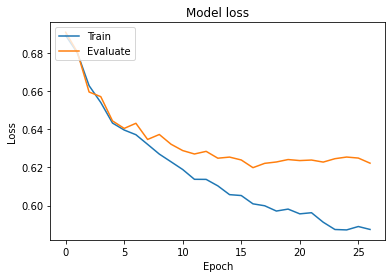

	AVG Loss: 0.527450; Accurancy: 0.7649; F1_macro: 0.7078
	Class scores:
		NOT: 0.8369829683698298
		HOF: 0.5786163522012578
Fold-1
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]


Best Epoch: 16


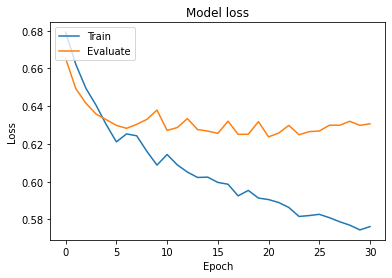

	AVG Loss: 0.528219; Accurancy: 0.7816; F1_macro: 0.7261
	Class scores:
		NOT: 0.8493647912885663
		HOF: 0.6028708133971291
Fold-2
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]


Best Epoch: 20


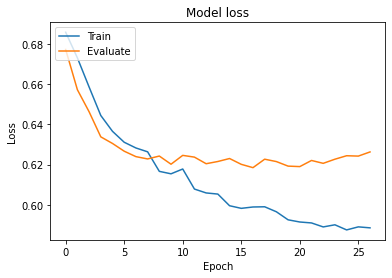

	AVG Loss: 0.516128; Accurancy: 0.7860; F1_macro: 0.7133
	Class scores:
		NOT: 0.8576429404900817
		HOF: 0.568904593639576
Fold-3
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]


Best Epoch: 16


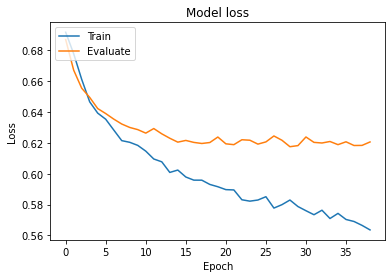

	AVG Loss: 0.517261; Accurancy: 0.7904; F1_macro: 0.7264
	Class scores:
		NOT: 0.8586635127143701
		HOF: 0.5942275042444821
Fold-4
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]


Best Epoch: 28


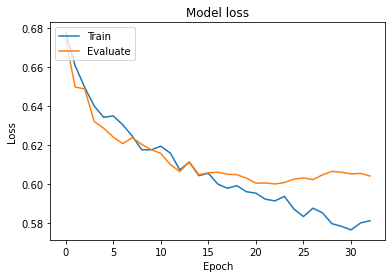

	AVG Loss: 0.525993; Accurancy: 0.7772; F1_macro: 0.7158
	Class scores:
		NOT: 0.8479041916167664
		HOF: 0.5836065573770493
===================================SUMMARY===================================
	AVG Accurancy: 0.7800; AVG F1_macro: 0.7179
	AVG Class scores: 
		NOT: 0.8501
		HOF: 0.5856
Accuracy for label 0: 0.8340
F1 for label 0: 0.8520
Accuracy for label 1: 0.6180
F1 for label 1: 0.5840
Macro F1 Score: 0.7179
Acc Score: 0.7800
------------------------------
Total 5-Fold Time: [16, 18, 16, 23, 19]
Total 5-Fold Time: 92
Avg Fold Time: 18.4
Avg Epoch Time 0.0
Num of Epoches: [27, 31, 27, 39, 33]



Best Epoch: 22


In [ ]:
data_idxs = list(range(train_dataset.__len__()))
data_labels = [train_dataset.examples[i][1] for i in data_idxs]
label_maps = {"NOT": 0, "HOF":1}
avg_scores = {'f1_0': [],'f1_1':[],'acc_0': [],'acc_1': [], 'macro_f1': [], 'macro_acc': [], 'acc': [],'labels': {k:[] for k in label_maps.keys()}}
criterion = nn.CrossEntropyLoss()
total_time = []
total_epoch = []
epoches = []
for idx, (train_index, test_index) in enumerate(kfold.split(data_idxs, data_labels)):
    start = time.time()
    model = MLP2(hidden_dim, num_labels, embedded_matrix.shape[0], embedded_matrix.shape[1], pad_idx,  dropout_prob, vectors=embedded_matrix, requires_grad=True)
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    eval_subsampler = torch.utils.data.SubsetRandomSampler(test_index)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    eval_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=eval_subsampler)
    logger.info(f"Fold-{idx}")
    best_model, best_epoch, epoch_time = train(model, criterion, optimizer, train_iter, eval_iter)
    print(f"\nBest Epoch: {best_epoch}")
    epoches.append(len(list(epoch_time.values())))
    total_epoch.append(round(np.mean(list(epoch_time.values()))))
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    loss, scores, reports = eval(best_model, criterion, test_iter)
    logger.info(f"\tAVG Loss: {loss:.6f}; Accurancy: {scores[0]:.4f}; F1_macro: {scores[5]:.4f}")
    logger.info(f"\tClass scores:")
    avg_scores['acc'].append(scores[0])
    avg_scores['f1_0'].append(scores[1])
    avg_scores['f1_1'].append(scores[2])
    avg_scores['acc_0'].append(scores[3])
    avg_scores['acc_1'].append(scores[4])
    avg_scores['macro_f1'].append(scores[5])
    for label in label_maps.keys():
        avg_scores['labels'][label].append(reports[label]['f1-score'])
        logger.info(f"\t\t{label}: {reports[label]['f1-score']}")
    total_time.append(get_total_time(start))
logger.info(f"{'='*35}SUMMARY{'='*35}")
logger.info(f"\tAVG Accurancy: {(sum(avg_scores['acc'])/num_fold):.4f}; AVG F1_macro: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info("\tAVG Class scores: ")
for label in label_maps.keys():
    logger.info(f"\t\t{label}: {(sum(avg_scores['labels'][label])/num_fold):.4f}")
logger.info(f"Accuracy for label 0: {(sum(avg_scores['acc_0'])/num_fold):.4f}")
logger.info(f"F1 for label 0: {(sum(avg_scores['f1_0'])/num_fold):.4f}")
logger.info(f"Accuracy for label 1: {(sum(avg_scores['acc_1'])/num_fold):.4f}")
logger.info(f"F1 for label 1: {(sum(avg_scores['f1_1'])/num_fold):.4f}")
logger.info(f"Macro F1 Score: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info(f"Acc Score: {(sum(avg_scores['acc'])/num_fold):.4f}")
logger.info("-"*30)
logger.info(f'Total 5-Fold Time: {total_time}')
logger.info(f'Total 5-Fold Time: {np.sum(total_time)}')
logger.info(f'Avg Fold Time: {np.mean(total_time)}')
logger.info(f'Avg Epoch Time {np.mean(total_epoch)}')
logger.info(f'Num of Epoches: {epoches}')

### With HateDict

Fold-0


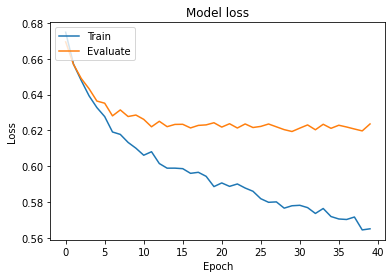

	AVG Loss: 0.526364; Accurancy: 0.7789; F1_macro: 0.7214
	Class scores:
		NOT: 0.8480096501809408
		HOF: 0.594855305466238
Fold-1
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]


Best Epoch: 29


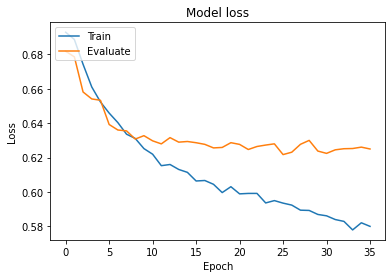

	AVG Loss: 0.515016; Accurancy: 0.7886; F1_macro: 0.7248
	Class scores:
		NOT: 0.8573120189461221
		HOF: 0.5922165820642977
Fold-2
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]


Best Epoch: 25


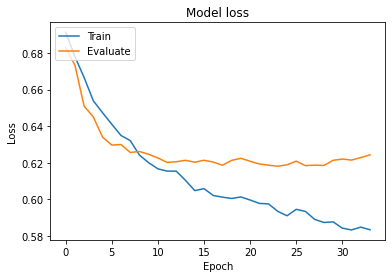

	AVG Loss: 0.528295; Accurancy: 0.7754; F1_macro: 0.7220
	Class scores:
		NOT: 0.8439024390243902
		HOF: 0.6
Fold-3
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]


Best Epoch: 23


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


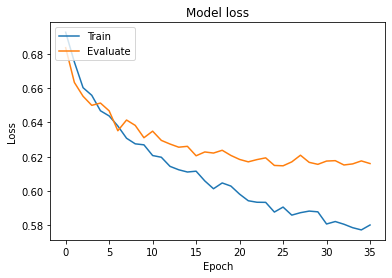

	AVG Loss: 0.515188; Accurancy: 0.7904; F1_macro: 0.7264
	Class scores:
		NOT: 0.8586635127143701
		HOF: 0.5942275042444821
Fold-4
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]


Best Epoch: 25


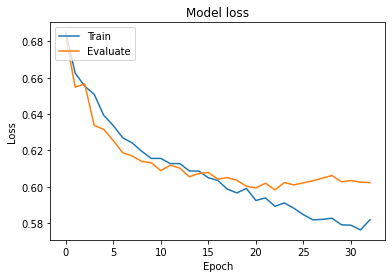

	AVG Loss: 0.529284; Accurancy: 0.7728; F1_macro: 0.7190
	Class scores:
		NOT: 0.8419768151311775
		HOF: 0.5959438377535102
===================================SUMMARY===================================
	AVG Accurancy: 0.7812; AVG F1_macro: 0.7227
	AVG Class scores: 
		NOT: 0.8500
		HOF: 0.5954
Accuracy for label 0: 0.8300
F1 for label 0: 0.8500
Accuracy for label 1: 0.6380
F1 for label 1: 0.5940
Macro F1 Score: 0.7227
Acc Score: 0.7812



Best Epoch: 22


------------------------------
Total 5-Fold Time: [35, 32, 30, 32, 29]
Total 5-Fold Time: 158
Avg Fold Time: 31.6
Avg Epoch Time 0.0
Num of Epoches: [40, 36, 34, 36, 33]


In [ ]:
data_idxs = list(range(train_dataset.__len__()))
data_labels = [train_dataset.examples[i][1] for i in data_idxs]
label_maps = {"NOT": 0, "HOF":1}
avg_scores = {'f1_0': [],'f1_1':[],'acc_0': [],'acc_1': [], 'macro_f1': [], 'macro_acc': [], 'acc': [],'labels': {k:[] for k in label_maps.keys()}}
criterion = nn.CrossEntropyLoss()
total_time = []
total_epoch = []
epoches = []
for idx, (train_index, test_index) in enumerate(kfold.split(data_idxs, data_labels)):
    start = time.time()
    model = MLP(hidden_dim, num_labels, embedded_matrix.shape[0], embedded_matrix.shape[1], pad_idx,  dropout_prob, vectors=embedded_matrix, use_hatedict=True, requires_grad=True) 
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    eval_subsampler = torch.utils.data.SubsetRandomSampler(test_index)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
    eval_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=eval_subsampler)
    logger.info(f"Fold-{idx}")
    best_model, best_epoch, epoch_time = train_hate(model, criterion, optimizer, train_iter, eval_iter)
    print(f"\nBest Epoch: {best_epoch}")
    epoches.append(len(list(epoch_time.values())))
    total_epoch.append(round(np.mean(list(epoch_time.values()))))
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    loss, scores, reports = eval_hate(best_model, criterion, test_iter)
    logger.info(f"\tAVG Loss: {loss:.6f}; Accurancy: {scores[0]:.4f}; F1_macro: {scores[5]:.4f}")
    logger.info(f"\tClass scores:")
    avg_scores['acc'].append(scores[0])
    avg_scores['f1_0'].append(scores[1])
    avg_scores['f1_1'].append(scores[2])
    avg_scores['acc_0'].append(scores[3])
    avg_scores['acc_1'].append(scores[4])
    avg_scores['macro_f1'].append(scores[5])
    for label in label_maps.keys():
        avg_scores['labels'][label].append(reports[label]['f1-score'])
        logger.info(f"\t\t{label}: {reports[label]['f1-score']}")
    total_time.append(get_total_time(start))
logger.info(f"{'='*35}SUMMARY{'='*35}")
logger.info(f"\tAVG Accurancy: {(sum(avg_scores['acc'])/num_fold):.4f}; AVG F1_macro: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info("\tAVG Class scores: ")
for label in label_maps.keys():
    logger.info(f"\t\t{label}: {(sum(avg_scores['labels'][label])/num_fold):.4f}")
logger.info(f"Accuracy for label 0: {(sum(avg_scores['acc_0'])/num_fold):.4f}")
logger.info(f"F1 for label 0: {(sum(avg_scores['f1_0'])/num_fold):.4f}")
logger.info(f"Accuracy for label 1: {(sum(avg_scores['acc_1'])/num_fold):.4f}")
logger.info(f"F1 for label 1: {(sum(avg_scores['f1_1'])/num_fold):.4f}")
logger.info(f"Macro F1 Score: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info(f"Acc Score: {(sum(avg_scores['acc'])/num_fold):.4f}")
logger.info("-"*30)
logger.info(f'Total 5-Fold Time: {total_time}')
logger.info(f'Total 5-Fold Time: {np.sum(total_time)}')
logger.info(f'Avg Fold Time: {np.mean(total_time)}')
logger.info(f'Avg Epoch Time {np.mean(total_epoch)}')
logger.info(f'Num of Epoches: {epoches}')

## Word2vec + BiLSTM

### Parameters

In [20]:
# Model Options
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device
embed_dim = 300 # embed dim
lstm_hidden_dim = 128 # lstm hidden dim
dropout_prob = 0.6 # Dropout prob
bidirectional = True # bidirectional
num_lstm_layers = 1  # Num Lstm Layers
pad_idx = 0 # Padding
num_labels = 2 # num labels

# Training Options
num_epochs = 100 # Epoch
num_fold = 5 # Num fold
batch_size = 32
early_stop = 10 # Early Stop
learning_rate = 2e-5 # learning rate
loss_function = nn.CrossEntropyLoss() # Loss Function 

kfold =  StratifiedKFold(n_splits=num_fold, random_state=1, shuffle=True)

### Normal Case

Fold-0
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


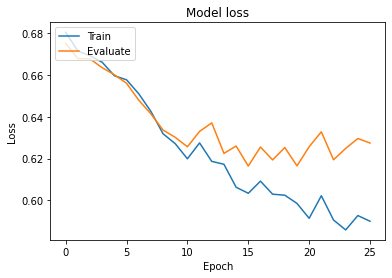


Best Epoch: 15
	Eval:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:683: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.num_layers, self.dropout, self.training, self.bidirectional)
	AVG Loss: 0.528649; Accurancy: 0.7947; F1_macro: 0.7449
	Class scores:
		NOT: 0.8576642335766422
		HOF: 0.6320754716981132
Fold-1


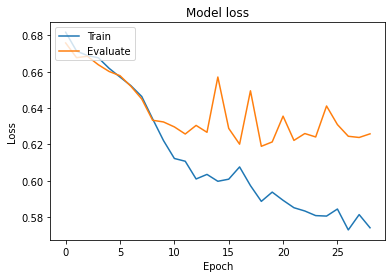


Best Epoch: 18
	AVG Loss: 0.515441; Accurancy: 0.8070; F1_macro: 0.7198
	Class scores:
		NOT: 0.8761261261261262
		HOF: 0.5634920634920635
Fold-2


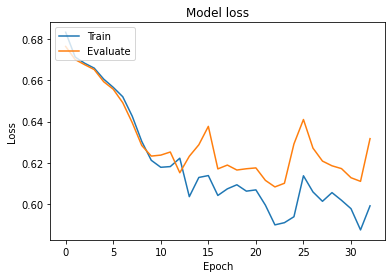


Best Epoch: 22
	AVG Loss: 0.502054; Accurancy: 0.8263; F1_macro: 0.7573
	Class scores:
		NOT: 0.8867276887871853
		HOF: 0.6278195488721805
Fold-3


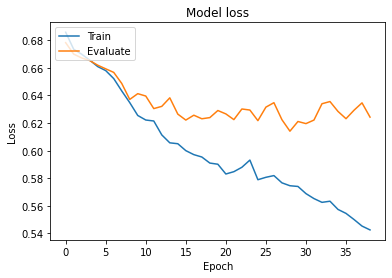


Best Epoch: 28
	AVG Loss: 0.522728; Accurancy: 0.7825; F1_macro: 0.7341
	Class scores:
		NOT: 0.8474784747847478
		HOF: 0.620795107033639
Fold-4


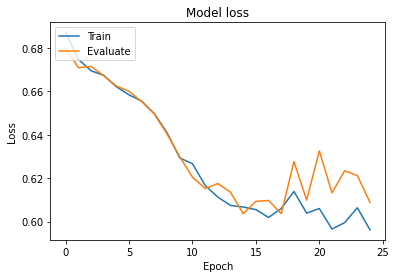


Best Epoch: 14
	AVG Loss: 0.536879; Accurancy: 0.7807; F1_macro: 0.7242
	Class scores:
		NOT: 0.8490338164251208
		HOF: 0.5993589743589743
===================================SUMMARY===================================
	AVG Accurancy: 0.7982; AVG F1_macro: 0.7361
	AVG Class scores: 
		NOT: 0.8634
		HOF: 0.6087
Accuracy for label 0: 0.8580
F1 for label 0: 0.8660
Accuracy for label 1: 0.6240
F1 for label 1: 0.6080
Macro F1 Score: 0.7361
Acc Score: 0.7982
------------------------------
Total 5-Fold Time: [51, 41, 47, 56, 36]
Total 5-Fold Time: 231
Avg Fold Time: 46.2
Avg Epoch Time 1.0
Num of Epoches: [26, 29, 33, 39, 25]


In [21]:
data_idxs = list(range(train_dataset.__len__()))
data_labels = [train_dataset.examples[i][1] for i in data_idxs]
label_maps = {"NOT": 0, "HOF":1}
avg_scores = {'f1_0': [],'f1_1':[],'acc_0': [],'acc_1': [], 'macro_f1': [], 'macro_acc': [], 'acc': [],'labels': {k:[] for k in label_maps.keys()}}
criterion = nn.CrossEntropyLoss()
total_time = []
total_epoch = []
epoches = []
for idx, (train_index, test_index) in enumerate(kfold.split(data_idxs, data_labels)):
    start = time.time()
    model = TextLSTM(lstm_hidden_dim, bidirectional, num_lstm_layers, len(dataset_vocab), embedded_matrix.shape[1], pad_idx, num_labels, dropout_prob, vectors=embedded_matrix, requires_grad=True)
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    eval_subsampler = torch.utils.data.SubsetRandomSampler(test_index)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler, collate_fn=MyDataset.collate_fn)
    eval_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=eval_subsampler, collate_fn=MyDataset.collate_fn)
    logger.info(f"Fold-{idx}")
    best_model, best_epoch, epoch_time = train(model, criterion, optimizer, train_iter, eval_iter)
    logger.info(f"\nBest Epoch: {best_epoch}")
    epoches.append(len(list(epoch_time.values())))
    total_epoch.append(round(np.mean(list(epoch_time.values()))))
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=MyDataset.collate_fn)
    loss, scores, reports = eval(best_model, criterion, test_iter)
    logger.info(f"\tAVG Loss: {loss:.6f}; Accurancy: {scores[0]:.4f}; F1_macro: {scores[5]:.4f}")
    logger.info(f"\tClass scores:")
    avg_scores['acc'].append(scores[0])
    avg_scores['f1_0'].append(scores[1])
    avg_scores['f1_1'].append(scores[2])
    avg_scores['acc_0'].append(scores[3])
    avg_scores['acc_1'].append(scores[4])
    avg_scores['macro_f1'].append(scores[5])
    for label in label_maps.keys():
        avg_scores['labels'][label].append(reports[label]['f1-score'])
        logger.info(f"\t\t{label}: {reports[label]['f1-score']}")
    total_time.append(get_total_time(start))
logger.info(f"{'='*35}SUMMARY{'='*35}")
logger.info(f"\tAVG Accurancy: {(sum(avg_scores['acc'])/num_fold):.4f}; AVG F1_macro: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info("\tAVG Class scores: ")
for label in label_maps.keys():
    logger.info(f"\t\t{label}: {(sum(avg_scores['labels'][label])/num_fold):.4f}")
logger.info(f"Accuracy for label 0: {(sum(avg_scores['acc_0'])/num_fold):.4f}")
logger.info(f"F1 for label 0: {(sum(avg_scores['f1_0'])/num_fold):.4f}")
logger.info(f"Accuracy for label 1: {(sum(avg_scores['acc_1'])/num_fold):.4f}")
logger.info(f"F1 for label 1: {(sum(avg_scores['f1_1'])/num_fold):.4f}")
logger.info(f"Macro F1 Score: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info(f"Acc Score: {(sum(avg_scores['acc'])/num_fold):.4f}")
logger.info("-"*30)
logger.info(f'Total 5-Fold Time: {total_time}')
logger.info(f'Total 5-Fold Time: {np.sum(total_time)}')
logger.info(f'Avg Fold Time: {np.mean(total_time)}')
logger.info(f'Avg Epoch Time {np.mean(total_epoch)}')
logger.info(f'Num of Epoches: {epoches}')

### With HateDict

Fold-0
	Epoch 0:   0%|          | 0/147 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


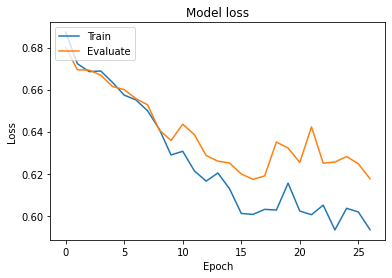

	Eval:   0%|          | 0/36 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:683: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /pytorch/aten/src/ATen/native/cudnn/RNN.cpp:924.)
  self.num_layers, self.dropout, self.training, self.bidirectional)
	Eval:  47%|████▋     | 17/36 [00:00<00:00, 161.67it/s]


Best Epoch: 16


	AVG Loss: 0.534313; Accurancy: 0.7825; F1_macro: 0.7341
	Class scores:
		NOT: 0.8474784747847478
		HOF: 0.620795107033639
Fold-1


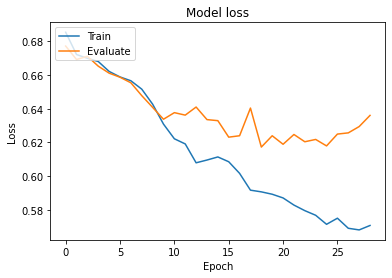

	Eval:  50%|█████     | 18/36 [00:00<00:00, 176.94it/s]


Best Epoch: 18


	AVG Loss: 0.510671; Accurancy: 0.8096; F1_macro: 0.7453
	Class scores:
		NOT: 0.8733216579100993
		HOF: 0.617283950617284
Fold-2


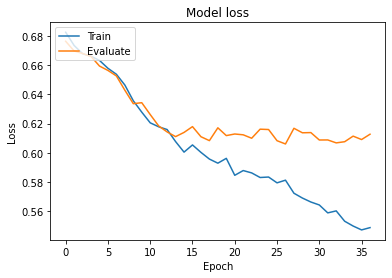

	Eval:  47%|████▋     | 17/36 [00:00<00:00, 166.43it/s]


Best Epoch: 26


	AVG Loss: 0.526330; Accurancy: 0.7860; F1_macro: 0.7126
	Class scores:
		NOT: 0.8578088578088577
		HOF: 0.5673758865248227
Fold-3


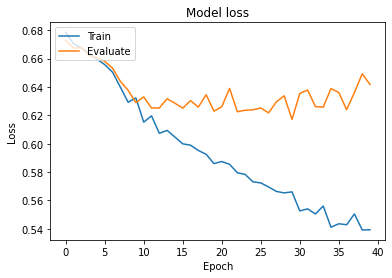

	Eval:  44%|████▍     | 16/36 [00:00<00:00, 155.11it/s]


Best Epoch: 29


	AVG Loss: 0.495972; Accurancy: 0.8140; F1_macro: 0.7373
	Class scores:
		NOT: 0.8792710706150341
		HOF: 0.5954198473282444
Fold-4


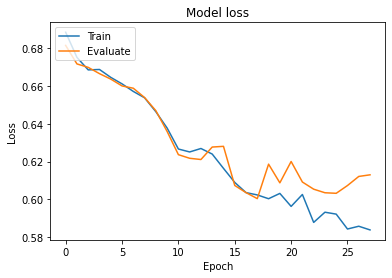

	Eval:  50%|█████     | 18/36 [00:00<00:00, 174.32it/s]


Best Epoch: 17


	AVG Loss: 0.509689; Accurancy: 0.8105; F1_macro: 0.7519
	Class scores:
		NOT: 0.872491145218418
		HOF: 0.6313993174061434
===================================SUMMARY===================================
	AVG Accurancy: 0.8005; AVG F1_macro: 0.7363
	AVG Class scores: 
		NOT: 0.8661
		HOF: 0.6065
Accuracy for label 0: 0.8660
F1 for label 0: 0.8660
Accuracy for label 1: 0.6100
F1 for label 1: 0.6080
Macro F1 Score: 0.7363
Acc Score: 0.8005
------------------------------
Total 5-Fold Time: [46, 49, 63, 68, 48]
Total 5-Fold Time: 274
Avg Fold Time: 54.8
Avg Epoch Time 1.0
Num of Epoches: [27, 29, 37, 40, 28]


In [22]:
data_idxs = list(range(train_dataset.__len__()))
data_labels = [train_dataset.examples[i][1] for i in data_idxs]
data_idxs = list(range(train_dataset.__len__()))
label_maps = {"NOT": 0, "HOF":1}
avg_scores = {'f1_0': [],'f1_1':[],'acc_0': [],'acc_1': [], 'macro_f1': [], 'macro_acc': [], 'acc': [],'labels': {k:[] for k in label_maps.keys()}}
criterion = nn.CrossEntropyLoss()
total_time = []
total_epoch = []
epoches = []
for idx, (train_index, test_index) in enumerate(kfold.split(data_idxs, data_labels)):
    start = time.time()
    model = TextLSTM(lstm_hidden_dim, bidirectional, num_lstm_layers, len(dataset_vocab), embedded_matrix.shape[1], pad_idx, num_labels, dropout_prob, vectors=embedded_matrix, use_hatedict=True, requires_grad=True)
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    eval_subsampler = torch.utils.data.SubsetRandomSampler(test_index)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler, collate_fn=MyDataset.collate_fn)
    eval_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=eval_subsampler, collate_fn=MyDataset.collate_fn)
    logger.info(f"Fold-{idx}")
    best_model, best_epoch, epoch_time = train_hate(model, criterion, optimizer, train_iter, eval_iter)
    print(f"\nBest Epoch: {best_epoch}")
    epoches.append(len(list(epoch_time.values())))
    total_epoch.append(round(np.mean(list(epoch_time.values()))))
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=MyDataset.collate_fn)
    loss, scores, reports = eval_hate(best_model, criterion, test_iter)
    logger.info(f"\tAVG Loss: {loss:.6f}; Accurancy: {scores[0]:.4f}; F1_macro: {scores[5]:.4f}")
    logger.info(f"\tClass scores:")
    avg_scores['acc'].append(scores[0])
    avg_scores['f1_0'].append(scores[1])
    avg_scores['f1_1'].append(scores[2])
    avg_scores['acc_0'].append(scores[3])
    avg_scores['acc_1'].append(scores[4])
    avg_scores['macro_f1'].append(scores[5])
    for label in label_maps.keys():
        avg_scores['labels'][label].append(reports[label]['f1-score'])
        logger.info(f"\t\t{label}: {reports[label]['f1-score']}")
    total_time.append(get_total_time(start))
logger.info(f"{'='*35}SUMMARY{'='*35}")
logger.info(f"\tAVG Accurancy: {(sum(avg_scores['acc'])/num_fold):.4f}; AVG F1_macro: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info("\tAVG Class scores: ")
for label in label_maps.keys():
    logger.info(f"\t\t{label}: {(sum(avg_scores['labels'][label])/num_fold):.4f}")
logger.info(f"Accuracy for label 0: {(sum(avg_scores['acc_0'])/num_fold):.4f}")
logger.info(f"F1 for label 0: {(sum(avg_scores['f1_0'])/num_fold):.4f}")
logger.info(f"Accuracy for label 1: {(sum(avg_scores['acc_1'])/num_fold):.4f}")
logger.info(f"F1 for label 1: {(sum(avg_scores['f1_1'])/num_fold):.4f}")
logger.info(f"Macro F1 Score: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info(f"Acc Score: {(sum(avg_scores['acc'])/num_fold):.4f}")
logger.info("-"*30)
logger.info(f'Total 5-Fold Time: {total_time}')
logger.info(f'Total 5-Fold Time: {np.sum(total_time)}')
logger.info(f'Avg Fold Time: {np.mean(total_time)}')
logger.info(f'Avg Epoch Time {np.mean(total_epoch)}')
logger.info(f'Num of Epoches: {epoches}')

## Word2Vec + CNN

### Parameters

In [41]:
# Model Options
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device
embed_dim = 300 # embed dim
dropout_prob = 0.6 # Dropout prob
num_filters = 300 # num filters
pad_idx = 0 # Padding
num_labels = 2 # num labels

# Training Options
num_epochs = 100 # Epoch
num_fold = 5 # Num fold
batch_size = 32
early_stop = 30 # Early Stop
learning_rate = 2e-5 # learning rate
loss_function = nn.CrossEntropyLoss() # Loss Function 

kfold =  StratifiedKFold(n_splits=num_fold, random_state=1, shuffle=True)

### Normal Case

Fold-0
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


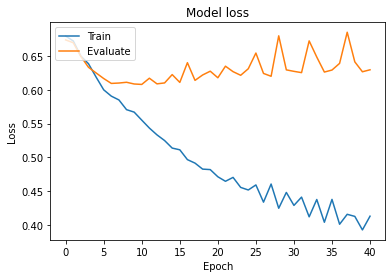


Best Epoch: 10
	AVG Loss: 0.500490; Accurancy: 0.7947; F1_macro: 0.7458
	Class scores:
		NOT: 0.8573170731707317
		HOF: 0.6343749999999999
Fold-1


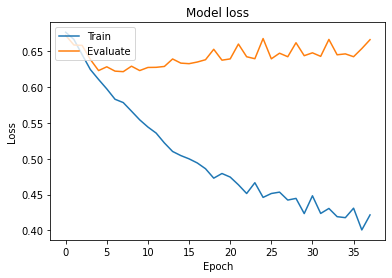


Best Epoch: 7
	AVG Loss: 0.499571; Accurancy: 0.7956; F1_macro: 0.7411
	Class scores:
		NOT: 0.8598917618761275
		HOF: 0.6223662884927066
Fold-2


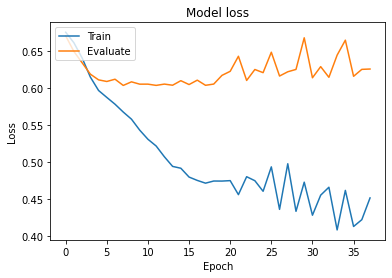


Best Epoch: 7
	AVG Loss: 0.487668; Accurancy: 0.8167; F1_macro: 0.7586
	Class scores:
		NOT: 0.8769864626250736
		HOF: 0.6402753872633391
Fold-3


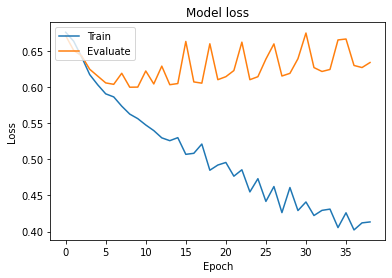


Best Epoch: 8
	AVG Loss: 0.488685; Accurancy: 0.8184; F1_macro: 0.7636
	Class scores:
		NOT: 0.8774422735346359
		HOF: 0.6497461928934011
Fold-4


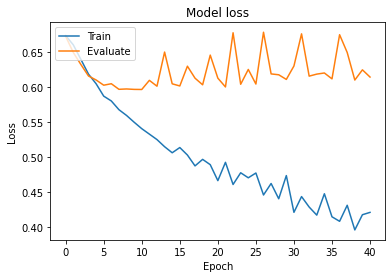


Best Epoch: 10
	AVG Loss: 0.501451; Accurancy: 0.8026; F1_macro: 0.7474
	Class scores:
		NOT: 0.8655110579796772
		HOF: 0.6293245469522241
===================================SUMMARY===================================
	AVG Accurancy: 0.8056; AVG F1_macro: 0.7513
	AVG Class scores: 
		NOT: 0.8674
		HOF: 0.6352
Accuracy for label 0: 0.8520
F1 for label 0: 0.8700
Accuracy for label 1: 0.6700
F1 for label 1: 0.6340
Macro F1 Score: 0.7513
Acc Score: 0.8056
------------------------------
Total 5-Fold Time: [33, 30, 30, 31, 33]
Total 5-Fold Time: 157
Avg Fold Time: 31.4
Avg Epoch Time 0.0
Num of Epoches: [41, 38, 38, 39, 41]


In [42]:
data_idxs = list(range(train_dataset.__len__()))
data_labels = [train_dataset.examples[i][1] for i in data_idxs]
label_maps = {"NOT": 0, "HOF":1}
avg_scores = {'f1_0': [],'f1_1':[],'acc_0': [],'acc_1': [], 'macro_f1': [], 'macro_acc': [], 'acc': [],'labels': {k:[] for k in label_maps.keys()}}
criterion = nn.CrossEntropyLoss()
total_time = []
total_epoch = []
epoches = []
for idx, (train_index, test_index) in enumerate(kfold.split(data_idxs, data_labels)):
    start = time.time()
    model = TextCNN(num_filters, num_labels, MAX_SEQUENCE_LENGTH,embedded_matrix.shape[0], embed_dim, pad_idx, dropout_prob, vectors=embedded_matrix)
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    eval_subsampler = torch.utils.data.SubsetRandomSampler(test_index)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler, collate_fn=MyDataset.collate_fn)
    eval_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=eval_subsampler, collate_fn=MyDataset.collate_fn)
    logger.info(f"Fold-{idx}")
    best_model, best_epoch, epoch_time = train(model, criterion, optimizer, train_iter, eval_iter)
    logger.info(f"\nBest Epoch: {best_epoch}")
    epoches.append(len(list(epoch_time.values())))
    total_epoch.append(round(np.mean(list(epoch_time.values()))))
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=MyDataset.collate_fn)
    loss, scores, reports = eval(best_model, criterion, test_iter)
    logger.info(f"\tAVG Loss: {loss:.6f}; Accurancy: {scores[0]:.4f}; F1_macro: {scores[5]:.4f}")
    logger.info(f"\tClass scores:")
    avg_scores['acc'].append(scores[0])
    avg_scores['f1_0'].append(scores[1])
    avg_scores['f1_1'].append(scores[2])
    avg_scores['acc_0'].append(scores[3])
    avg_scores['acc_1'].append(scores[4])
    avg_scores['macro_f1'].append(scores[5])
    for label in label_maps.keys():
        avg_scores['labels'][label].append(reports[label]['f1-score'])
        logger.info(f"\t\t{label}: {reports[label]['f1-score']}")
    total_time.append(get_total_time(start))
logger.info(f"{'='*35}SUMMARY{'='*35}")
logger.info(f"\tAVG Accurancy: {(sum(avg_scores['acc'])/num_fold):.4f}; AVG F1_macro: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info("\tAVG Class scores: ")
for label in label_maps.keys():
    logger.info(f"\t\t{label}: {(sum(avg_scores['labels'][label])/num_fold):.4f}")
logger.info(f"Accuracy for label 0: {(sum(avg_scores['acc_0'])/num_fold):.4f}")
logger.info(f"F1 for label 0: {(sum(avg_scores['f1_0'])/num_fold):.4f}")
logger.info(f"Accuracy for label 1: {(sum(avg_scores['acc_1'])/num_fold):.4f}")
logger.info(f"F1 for label 1: {(sum(avg_scores['f1_1'])/num_fold):.4f}")
logger.info(f"Macro F1 Score: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info(f"Acc Score: {(sum(avg_scores['acc'])/num_fold):.4f}")
logger.info("-"*30)
logger.info(f'Total 5-Fold Time: {total_time}')
logger.info(f'Total 5-Fold Time: {np.sum(total_time)}')
logger.info(f'Avg Fold Time: {np.mean(total_time)}')
logger.info(f'Avg Epoch Time {np.mean(total_epoch)}')
logger.info(f'Num of Epoches: {epoches}')

### With HateDict

Fold-0
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


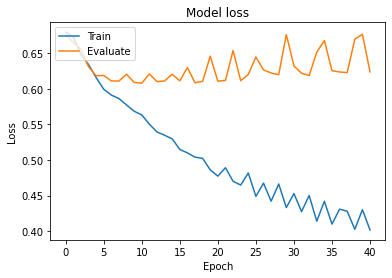


Best Epoch: 10
	AVG Loss: 0.496094; Accurancy: 0.8061; F1_macro: 0.7574
	Class scores:
		NOT: 0.8661417322834645
		HOF: 0.6486486486486487
Fold-1


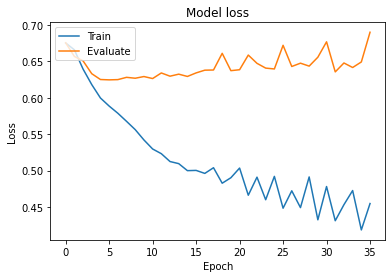


Best Epoch: 5
	AVG Loss: 0.503372; Accurancy: 0.8123; F1_macro: 0.7559
	Class scores:
		NOT: 0.8732227488151658
		HOF: 0.6385135135135136
Fold-2


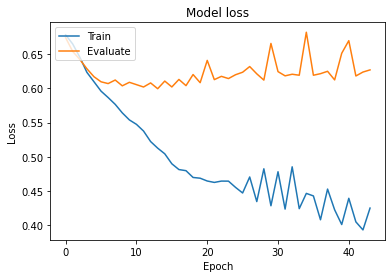


Best Epoch: 13
	AVG Loss: 0.514734; Accurancy: 0.7868; F1_macro: 0.7368
	Class scores:
		NOT: 0.8515577275503972
		HOF: 0.6220839813374806
Fold-3


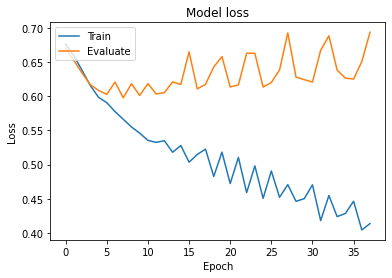


Best Epoch: 7
	AVG Loss: 0.477282; Accurancy: 0.8386; F1_macro: 0.7738
	Class scores:
		NOT: 0.8948571428571429
		HOF: 0.6528301886792452
Fold-4


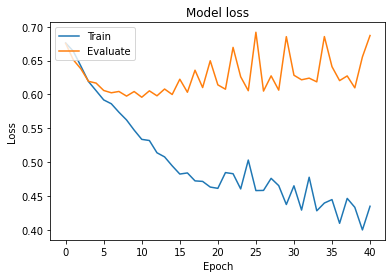


Best Epoch: 10
	AVG Loss: 0.508329; Accurancy: 0.7939; F1_macro: 0.7469
	Class scores:
		NOT: 0.8559166155732678
		HOF: 0.6379044684129429
===================================SUMMARY===================================
	AVG Accurancy: 0.8075; AVG F1_macro: 0.7542
	AVG Class scores: 
		NOT: 0.8683
		HOF: 0.6400
Accuracy for label 0: 0.8540
F1 for label 0: 0.8680
Accuracy for label 1: 0.6760
F1 for label 1: 0.6400
Macro F1 Score: 0.7542
Acc Score: 0.8075
------------------------------
Total 5-Fold Time: [43, 38, 47, 40, 44]
Total 5-Fold Time: 212
Avg Fold Time: 42.4
Avg Epoch Time 0.0
Num of Epoches: [41, 36, 44, 38, 41]


In [43]:
data_idxs = list(range(train_dataset.__len__()))
data_labels = [train_dataset.examples[i][1] for i in data_idxs]
data_idxs = list(range(train_dataset.__len__()))
label_maps = {"NOT": 0, "HOF":1}
avg_scores = {'f1_0': [],'f1_1':[],'acc_0': [],'acc_1': [], 'macro_f1': [], 'macro_acc': [], 'acc': [],'labels': {k:[] for k in label_maps.keys()}}
criterion = nn.CrossEntropyLoss()
total_time = []
total_epoch = []
epoches = []
for idx, (train_index, test_index) in enumerate(kfold.split(data_idxs, data_labels)):
    start = time.time()
    model = TextCNN(num_filters, num_labels, MAX_SEQUENCE_LENGTH,embedded_matrix.shape[0], embed_dim, pad_idx, dropout_prob, use_hatedict=True, vectors=embedded_matrix)
    model.to(device)
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=1e-5)
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_index)
    eval_subsampler = torch.utils.data.SubsetRandomSampler(test_index)
    train_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler, collate_fn=MyDataset.collate_fn)
    eval_iter = DataLoader(train_dataset, batch_size=batch_size, sampler=eval_subsampler, collate_fn=MyDataset.collate_fn)
    logger.info(f"Fold-{idx}")
    best_model, best_epoch, epoch_time = train_hate(model, criterion, optimizer, train_iter, eval_iter)
    logger.info(f"\nBest Epoch: {best_epoch}")
    epoches.append(len(list(epoch_time.values())))
    total_epoch.append(round(np.mean(list(epoch_time.values()))))
    test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=MyDataset.collate_fn)
    loss, scores, reports = eval_hate(best_model, criterion, test_iter)
    logger.info(f"\tAVG Loss: {loss:.6f}; Accurancy: {scores[0]:.4f}; F1_macro: {scores[5]:.4f}")
    logger.info(f"\tClass scores:")
    avg_scores['acc'].append(scores[0])
    avg_scores['f1_0'].append(scores[1])
    avg_scores['f1_1'].append(scores[2])
    avg_scores['acc_0'].append(scores[3])
    avg_scores['acc_1'].append(scores[4])
    avg_scores['macro_f1'].append(scores[5])
    for label in label_maps.keys():
        avg_scores['labels'][label].append(reports[label]['f1-score'])
        logger.info(f"\t\t{label}: {reports[label]['f1-score']}")
    total_time.append(get_total_time(start))
logger.info(f"{'='*35}SUMMARY{'='*35}")
logger.info(f"\tAVG Accurancy: {(sum(avg_scores['acc'])/num_fold):.4f}; AVG F1_macro: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info("\tAVG Class scores: ")
for label in label_maps.keys():
    logger.info(f"\t\t{label}: {(sum(avg_scores['labels'][label])/num_fold):.4f}")
logger.info(f"Accuracy for label 0: {(sum(avg_scores['acc_0'])/num_fold):.4f}")
logger.info(f"F1 for label 0: {(sum(avg_scores['f1_0'])/num_fold):.4f}")
logger.info(f"Accuracy for label 1: {(sum(avg_scores['acc_1'])/num_fold):.4f}")
logger.info(f"F1 for label 1: {(sum(avg_scores['f1_1'])/num_fold):.4f}")
logger.info(f"Macro F1 Score: {(sum(avg_scores['macro_f1'])/num_fold):.4f}")
logger.info(f"Acc Score: {(sum(avg_scores['acc'])/num_fold):.4f}")
logger.info("-"*30)
logger.info(f'Total 5-Fold Time: {total_time}')
logger.info(f'Total 5-Fold Time: {np.sum(total_time)}')
logger.info(f'Avg Fold Time: {np.mean(total_time)}')
logger.info(f'Avg Epoch Time {np.mean(total_epoch)}')
logger.info(f'Num of Epoches: {epoches}')